# BI Master

## Autoencoders para detecção de esquemas de barreiras

### Introdução

Na área de avaliação de formações, a variação de pressão medida no interior do poço e sua derivada no tempo são avaliadas através de gráficos loglog em busca de valores de transmissibilidade ($\frac{k h}{\mu}$), dano à formação (_skin_), pressão extrapolada, etc.

A análise de padrões nesses gráficos também permite estimar a presença de barreiras nas proximidades do poço, conforme figura abaixo.

<img src="img/modelos.png" style="width:700px">

### Objetivo do trabalho

Este trabalho consistiu na investigação de um conjunto de treinamento de 10.000 testes de formação sintéticos contemplando 6 configurações de barreiras: reservatório infinito (sem barreiras), reservatório com 1 barreira, 2 barreiras em 90 graus, 3 barreiras em U, 2 barreiras paralelas e fechado. 

Esses dados foram segregados e manipulados de diferentes formas para treinar redes neurais do tipo [autoencoder](https://blog.keras.io/building-autoencoders-in-keras.html), e as camadas de codificação foram então usadas para segregar os diversos modelos entre si atingindo ótimos resultados.

Essa solução possui duas aplicações práticas no dia a dia da avaliação de reservatórios conforme descritas abaixo.

1. Construção de assistentes de interpretação de testes capazes de sugerir um esquema de barreiras com base nos dados brutos de variação de pressão e sua derivada;
2. Viabilização da comparação de testes em diferentes campos através da redução de dimensionalidade dos dados.

### Metodologia

#### Conjunto de entrada

Este trabalho utilizou um conjunto de 10.000 testes de formação sintéticos. Esses testes foram construídos usando amostras aleatórias de diversas propriedades de reservatórios, conforme apresentado na tabela abaixo.

|Propriedade|Valor mínimo|Valor máximo|
|---|---|---|
|Permeabilidade — k (md)|50|1000|
|Altura do reservatório — h (m)|10|300|
|Fator Volume Formação do Óleo — Bo (m3/m3)|1|2|
|Pressão inicial — Pi (kgf/cm2)|50|600|
|Dano à formação — skin|-2|5|
|*Porosidade*\*|20%|20%|20%|
|*Compressibildade total (cm2/kgf)*\*|1e-5|1e-5|1e
|*Viscosidade — $\mu (cp)$*\*|1|1|

\* As propriedades marcadas com * não tiveram variação entre os modelos

Cada um dos reservatórios foi submetido ao esquema de fluxos e estáticas apresentado abaixo.

|Etapa|Duração|Vazão|
|---|---|---|
|Fluxo 1|10h|200 m3/d|
|Estática 1|24h|0|
|Fluxo 2|50h|200 m3/d|
|Estática 2|48h|0|

### Importação das bibliotecas de interesse

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [2]:
# Keras
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1

### Carregando os dados

O conjunto de dados de entrada possui 200Mb e encontra-se disponível para download no link a seguir:

[Download do conjunto de entrada](https://www.dropbox.com/s/l05mtq7un5wogib/10000_tests.csv?dl=0)

In [3]:
# Auxiliary functions
def visualize(t, original, predicted):
    fig, ax = plt.subplots(2,5,figsize=(12,6))
    options = list(range(10))
    predicted = predicted[np.random.choice(predicted.shape[0], 10, replace=False), :]
    for i in range(2):
        for j in range(5):
            idx = 2*i + j
            ax[i,j].plot(t, original[idx][1:499])
            ax[i,j].plot(t, original[idx][500:])
            ax[i,j].scatter(t, predicted[idx][1:499], alpha=0.2, color="green", s=3)
            ax[i,j].scatter(t, predicted[idx][500:], alpha=0.2, color="red", s=3)
            ax[i,j].semilogx()

            
# Normalize
def normalize(array):
    return (array - np.min(array))/(np.max(array) - np.min(array))

In [5]:
df = pd.read_csv("10000_tests.csv")

# transmissibility feature creation
df["trans"] = df["k"]*df["h"]/df["visc"]

# models distribution
df["model"].value_counts()

channel      1710
1 barrier    1668
infinite     1663
closed       1662
corner       1656
u shaped     1641
Name: model, dtype: int64

#### Distribuição dos parâmetros k, h, Bo, Pi e skin

![](img/range.png)

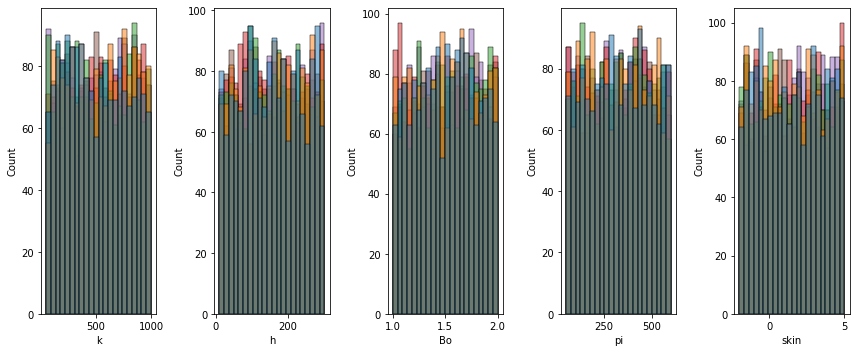

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(12,5), tight_layout=True)
for i,x in enumerate(["k", "h", "Bo", "pi", "skin"]):
    sns.histplot(df, x=x, hue="model", ax=axs[i], legend=False)

#### Apresentação de amostra do conjunto

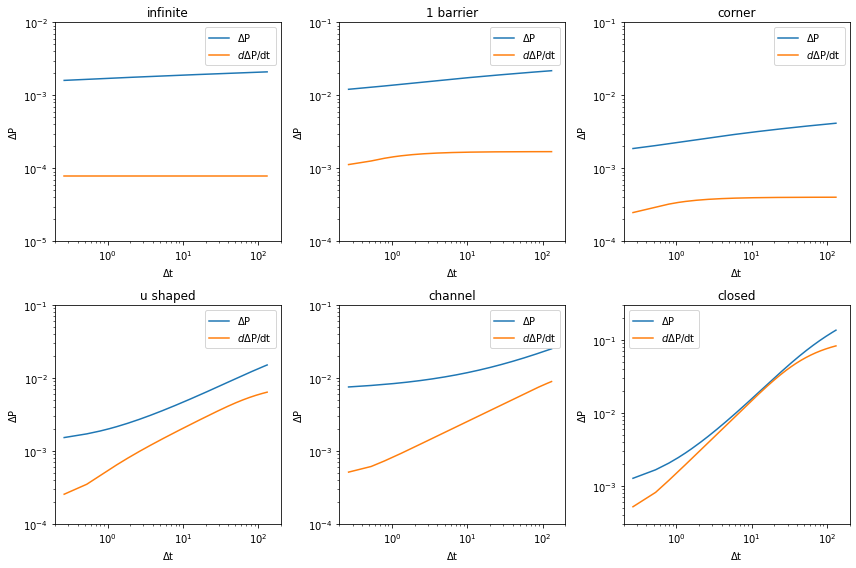

In [7]:
# Create time array
n_points = 500
t_schedule=[10.0,24.0,50.0,48.0]
t_schedule = np.array(t_schedule)
tk = np.linspace(0.001, np.sum(t_schedule), n_points)

# Get random sample of each model
models = ["infinite", "1 barrier", "corner", "u shaped", "channel", "closed"]
data = []
for mod in models:
    data.append(df[df["model"] == mod].sample(random_state=8))

# Plot each model
fig, axs = plt.subplots(2,3,figsize=(12,8),tight_layout=True)
lims = [(1e-4, 1e-1) for i in range(5)]
lims[0] = (1e-5, 1e-2)
lims.append((3e-4, 3e-1))
for i in range(2):
    for j in range(3):
        idx = i*3 + j
        axs[i,j].loglog(tk[1:-1], data[idx].values[0][14:512], label="$\Delta$P")
        axs[i,j].loglog(tk[1:-1], data[idx].values[0][514:-2], label="$d\Delta$P/dt")
        axs[i,j].set_title(models[idx])
        axs[i,j].set_xlabel("$\Delta$t")
        axs[i,j].set_ylabel("$\Delta$P")
        axs[i,j].set_xlim(2e-1, 2e2)
        axs[i,j].set_ylim(*lims[idx])
        axs[i,j].legend()

### Definição dos conjuntos de treino e teste

Inicialmente, foram construídos 3 conjuntos de treinamento e teste, conforme lista abaixo.

1. Contendo apenas os dados de variação de pressão ($\Delta P$);
2. Contendo apenas os dados de derivada da variação de pressão ($\frac{d\Delta P}{dlnt}$);
3. Contendo ambos os dados de variação de pressão e sua derivada.

Porém, como as variações de pressão são proporcionais ao logaritmo da variação do tempo no fenômeno físico de fluxo em meio poroso, também foram construídos 3 conjuntos adicionais com base no logaritmo dos 3 conjuntos iniciais:

4. Contendo o logaritmo dos dados do conjunto 1;
5. Contendo o logaritmo dos dados do conjunto 2;
6. Contendo o logaritmo dos dados do conjunto 3.

In [8]:
# Create time array
n_points = 500
t_schedule=[10.0,24.0,50.0,48.0]
t_schedule = np.array(t_schedule)
tk = np.linspace(0.001, np.sum(t_schedule), n_points)
tk = tk[1:-1]

# Get df values
X = df.values
X[X==0] = 1e-5
X_train_base, X_test_base = train_test_split(X, test_size=0.2, random_state=100, shuffle=True)

# Create and normalize train datasets
X_train_1 = normalize(X_train_base[:, 14:514].astype(float))
X_train_2 = normalize(X_train_base[:, 514:-2].astype(float))
X_train_3 = normalize(X_train_base[:, 14:-2].astype(float))
X_train_4 = normalize(np.log(X_train_base[:, 14:514].astype(float)))
X_train_5 = normalize(np.log(X_train_base[:, 514:-2].astype(float)))
X_train_6 = normalize(np.log(X_train_base[:, 14:-2].astype(float)))

# Create and normalize test datasets
X_test_1 = normalize(X_test_base[:, 14:514].astype(float))
X_test_2 = normalize(X_test_base[:, 514:-2].astype(float))
X_test_3 = normalize(X_test_base[:, 14:-2].astype(float))
X_test_4 = normalize(np.log(X_test_base[:, 14:514].astype(float)))
X_test_5 = normalize(np.log(X_test_base[:, 514:-2].astype(float)))
X_test_6 = normalize(np.log(X_test_base[:, 14:-2].astype(float)))

train_sets = [X_train_1, X_train_2, X_train_3, X_train_4, X_train_5, X_train_6]
test_sets  = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5, X_test_6] 

print(f"Conjuntos de treino:")
for i, train_set in enumerate(train_sets):
    print(f"\t{i+1}. {train_set.shape}")
print(f"Conjuntos de teste:")
for i, test_set in enumerate(test_sets):
    print(f"\t{i+1}. {test_set.shape}")

Conjuntos de treino:
	1. (8000, 500)
	2. (8000, 498)
	3. (8000, 998)
	4. (8000, 500)
	5. (8000, 498)
	6. (8000, 998)
Conjuntos de teste:
	1. (2000, 500)
	2. (2000, 498)
	3. (2000, 998)
	4. (2000, 500)
	5. (2000, 498)
	6. (2000, 998)


### Redes autoencoders

Autoencoders são algoritmos de compressão e descompressão implementados através de redes neurais. 

O treinamento desse tipo de rede é realizado definindo as saídas esperadas como cópias do conjunto de entrada podendo incluir pequena variações. A arquitetura dessas redes prevê dois blocos distintos: um de codificação e outro de decodificação.

<img src="img/autoencoder.png" style="width: 600px">

No primeiro bloco, o número de neurônios em cada camada diminui progressivamente, chegando ao mínimo na camada latente. A partir desta camada, o número de neurônios volta a crescer (usualmente de forma simétrica), chegando a uma camada de saída com a mesma quantidade de neurônios da camada de entrada.

A capacidade dessas redes de compactar a informação até a camada latente e reconstruí-la em seguida, leva à conclusão que a informação contida na camada latente é uma "representação mínima" dos dados de entrada. Assim, essa rede pode ser uma alternativa interessante na redução de dimensionalidade de conjuntos de dados complexos.

Assim, foram construídas 6 redes autoencoders diferentes (uma para cada conjunto de entrada), mas com as mesmas distribuições de camadas de codificação e decodificação, conforme apresentado na figura acima. Todas essas redes foram treinadas em 1000 épocas.

In [9]:
models = []
for i in range(len(train_sets)):
    # input layer
    input_layer = Input(shape=(train_sets[i].shape[1],))

    # encoding architecture
    encode_layer1 = Dense(512, activation='tanh')(input_layer)
    encode_layer2 = Dense(256, activation='tanh')(encode_layer1)
    encode_layer3 = Dense(128,  activation='tanh')(encode_layer2)
    encode_layer4 = Dense(64,  activation='tanh')(encode_layer3)

    # latent view
    latent_view   = Dense(32,  activation='tanh', activity_regularizer=l1(10e-5))(encode_layer4)

    # decoding architecture
    decode_layer1 = Dense(64,  activation='tanh')(latent_view)
    decode_layer2 = Dense(128, activation='tanh')(decode_layer1)
    decode_layer3 = Dense(256, activation='tanh')(decode_layer2)
    decode_layer4 = Dense(512, activation='tanh')(decode_layer3)

    # output layer
    output_layer  = Dense(train_sets[i].shape[1], activation="tanh")(decode_layer4)

    models.append(Model(input_layer, output_layer))

In [10]:
for i, (X_train, X_test) in enumerate(zip(train_sets, test_sets)):
    print(f"Started training model {i+1}")
    models[i].compile(optimizer='sgd', # SGD
                      loss=tensorflow.keras.losses.mean_squared_error,
                      metrics=["accuracy"])
    models[i].fit(X_train,
                  X_train,
                  epochs=1000, # 200, 300, 1000
                  batch_size=64,
                  validation_data=(X_test, X_test))
    print(f"Finished training model {i+1}\n\n\n\n")

Streaming output truncated to the last 5000 lines.
125/125 [==============================] - 0s 4ms/step - loss: 4.7021e-04 - accuracy: 0.0000e+00 - val_loss: 7.7058e-04 - val_accuracy: 0.0000e+00
Epoch 510/1000
125/125 [==============================] - 0s 4ms/step - loss: 5.2391e-04 - accuracy: 0.0000e+00 - val_loss: 8.7190e-04 - val_accuracy: 0.0000e+00
Epoch 511/1000
125/125 [==============================] - 0s 4ms/step - loss: 5.0603e-04 - accuracy: 0.0000e+00 - val_loss: 7.5808e-04 - val_accuracy: 0.0000e+00
Epoch 512/1000
125/125 [==============================] - 0s 4ms/step - loss: 6.2843e-04 - accuracy: 0.0000e+00 - val_loss: 8.6761e-04 - val_accuracy: 0.0000e+00
Epoch 513/1000
125/125 [==============================] - 0s 3ms/step - loss: 4.7777e-04 - accuracy: 0.0000e+00 - val_loss: 7.3359e-04 - val_accuracy: 0.0000e+00
Epoch 514/1000
125/125 [==============================] - 0s 4ms/step - loss: 5.3191e-04 - accuracy: 0.0000e+00 - val_loss: 8.4296e-04 - val_accuracy: 0.0

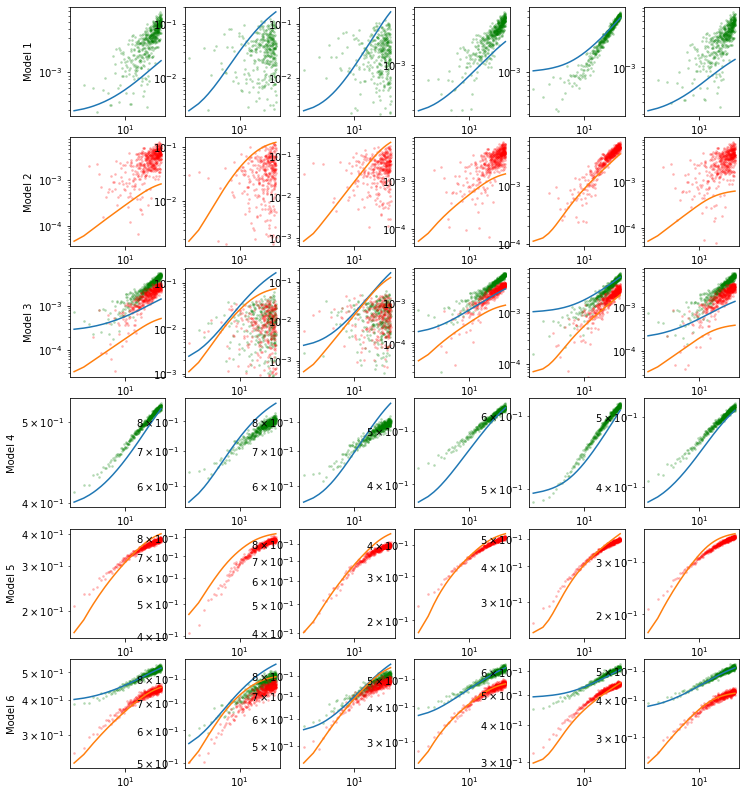

In [15]:
results = [model.predict(X_test) for (model, X_test) in zip(models, test_sets)]

fig, ax = plt.subplots(len(train_sets),6,figsize=(12,14))
options = list(range(6))
# results = results[np.random.choice(results.shape[0], 10, replace=False), :]
for i in range(len(train_sets)):
    for j in range(6):
        if j == 0:
            ax[i,j].set_ylabel(f"Model {i+1}")
        if i not in (1,4):
            ax[i,j].plot(tk, test_sets[i][j][1:499])
            ax[i,j].scatter(tk, results[i][j][1:499], alpha=0.2, color="green", s=3)
        else:
            ax[i,j].plot(tk, test_sets[i][j], color="#ff7f0e")
            ax[i,j].scatter(tk, results[i][j], alpha=0.2, color="red", s=3)
        if i in (2,5):
            ax[i,j].plot(tk, test_sets[i][j][500:])
            ax[i,j].scatter(tk, results[i][j][500:], alpha=0.2, color="red", s=3)
        ax[i,j].semilogx()
        ax[i,j].semilogy()

### Resultados obtidos

A figura acima apresenta gráficos de casos aleatórios do conjunto de entrada (linhas) e os resultados obtidos na camada de saída das respectivas redes (dispersões de pontos).

Os resultados indicam a superioridade dos modelos que usam dados logarítmicos. Dentre esses, o modelo 6, que usa todos os dados disponíveis, foi aquele que se aproximou mais das curvas de entrada.

É importante frisar que, apesar da estratégia de treinamento adotada, o objetivo dessas redes não é reconstruir perfeitamente o dado de entrada. O aprendizado da rede precisa ser suficiente para que ela torne-se capaz de compreender as diferenças entre os diversos esquemas de barreira possíveis no teste.


### Análise das representações mínimas dos testes

As camadas iniciais de cada uma das 6 redes autoencoders foram usadas para construir redes codificadoras. Em seguida, as novas redes foram usadas para construir representações mínimas de 32 dimensões dos dados de validação.

In [16]:
encoding_models = []
for model in models:
    layers = []
    new_model = Sequential()
    curr_layer = model.get_layer(index=0)
    new_model.add(curr_layer)
    curr_layer = model.get_layer(index=1)
    new_model.add(curr_layer)
    curr_layer = model.get_layer(index=2)
    new_model.add(curr_layer)
    curr_layer = model.get_layer(index=3)
    new_model.add(curr_layer)
    curr_layer = model.get_layer(index=4)
    new_model.add(curr_layer)
    curr_layer = model.get_layer(index=5)
    new_model.add(curr_layer)
    encoding_models.append(new_model)

Na figura abaixo, encontram-se representados os 2000 resultados de cada um dos 6 conjuntos de validação. Cada linha representa uma amostra do conjunto, e cada coluna, os valores obtidos em cada um dos neurônios da camada latente.

Os dados de validação foram previamente ordenados com base nos 6 esquemas de barreiras. Para os modelos de 1 a 3 (construídos sem pré-processamento logarítmico), há pouca diferenciação entre os blocos horizontais. Porém, a partir do modelo 4, é possível verificar uma clara separação em 6 grupos, culminando no modelo 6.

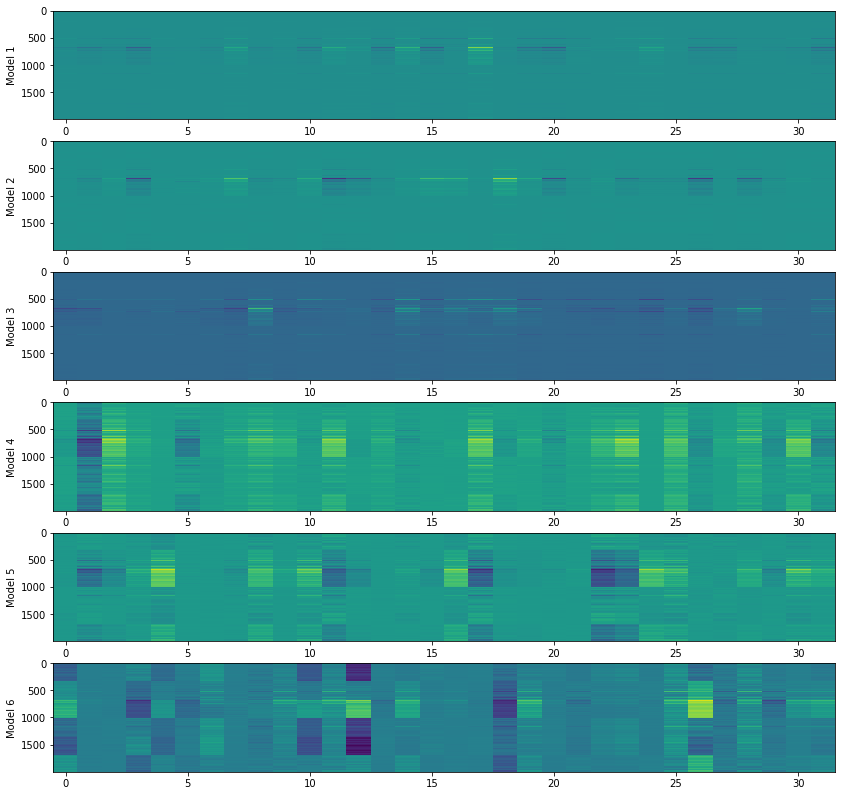

In [19]:
test_df = pd.DataFrame(X_test_base)
test_df = test_df.sort_values(0)
X_transmissibility = test_df.values[:, -1].astype(float)
X_transmissibility = 200*(X_transmissibility - np.min(X_transmissibility))/(np.max(X_transmissibility) - np.min(X_transmissibility))

X_validate_1 = normalize(test_df.values[:, 14:514].astype(float))
X_validate_2 = normalize(test_df.values[:, 514:-2].astype(float))
X_validate_3 = normalize(test_df.values[:, 14:-2].astype(float))
X_validate_4 = normalize(np.log(test_df.values[:, 14:514].astype(float)))
X_validate_5 = normalize(np.log(test_df.values[:, 514:-2].astype(float)))
X_validate_6 = normalize(np.log(test_df.values[:, 14:-2].astype(float)))

validation_sets = [X_validate_1, X_validate_2, X_validate_3, X_validate_4, X_validate_5, X_validate_6]

data = [encoder.predict(X_validate) for (encoder, X_validate) in zip(encoding_models, validation_sets)]

fig, ax = plt.subplots(len(validation_sets),1,figsize=(14,14))
for i in range(len(validation_sets)):
    ax[i].set_ylabel(f"Model {i+1}")
    ax[i].imshow(data[i], interpolation="nearest", aspect="auto")

#### Visualização em 2 dimensões

Os algoritmos [T-SNE](https://lvdmaaten.github.io/tsne/) e [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) foram usados para reduzir a dimensionalidade das representações de 32 para 2 dimensões e assim facilitar a visualização dos resultados.

**Usando o algoritmo T-SNE**

A figura abaixo apresenta os resultados obtidos com todos os modelos. Os melhores resultados, conforme esperado, foram obtidos usando o conjunto número 6 que contem os valores logarítimicos da variação de pressão e da sua derivada no tempo.

In [20]:
labels = test_df[0].values
tsne = TSNE(n_components=2, random_state=3)
transformed_sets = [tsne.fit_transform(dt) for dt in data]

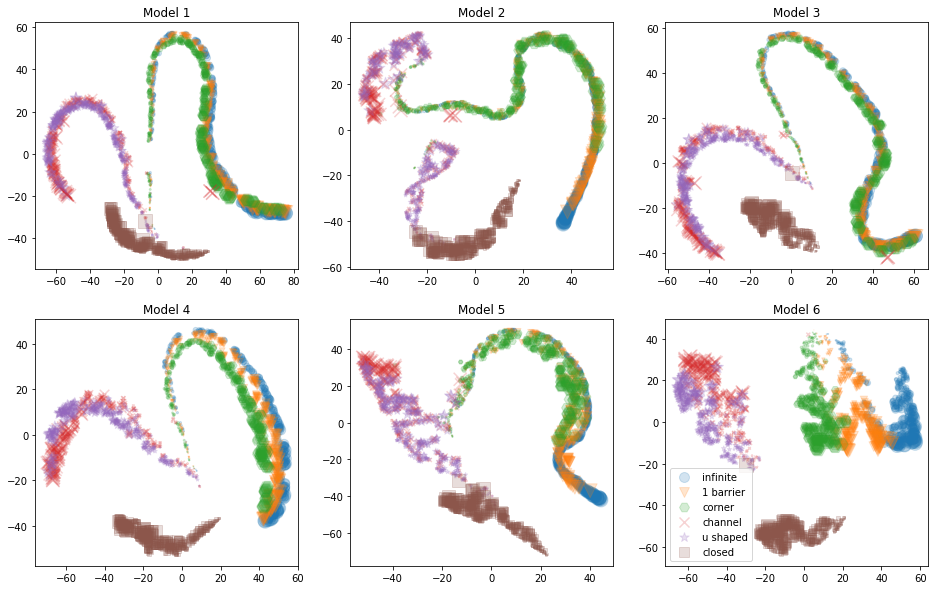

In [22]:
fig, ax = plt.subplots(2,3,figsize=(16,10))
model_names = ["infinite", "1 barrier", "corner", "channel", "u shaped", "closed"]
markers = ["o", "v", "H", "x", "*", "s"]
for i in range(2):
    for j in range(3):
        idx = 3*i + j
        for k,mdl in enumerate(model_names):
            ax[i,j].scatter(transformed_sets[idx][np.where(labels == mdl), 0], 
                            transformed_sets[idx][np.where(labels == mdl), 1], 
                            marker=markers[k], 
                            alpha=0.2, 
                            s=X_transmissibility[np.where(labels == mdl)],
                            label=mdl)
            ax[i,j].set_title(f"Model {idx+1}")
            if i == 1 and j == 2:
                ax[i,j].legend()

A figura abaixo apresenta os resultados do modelo 6 de forma ampliada.

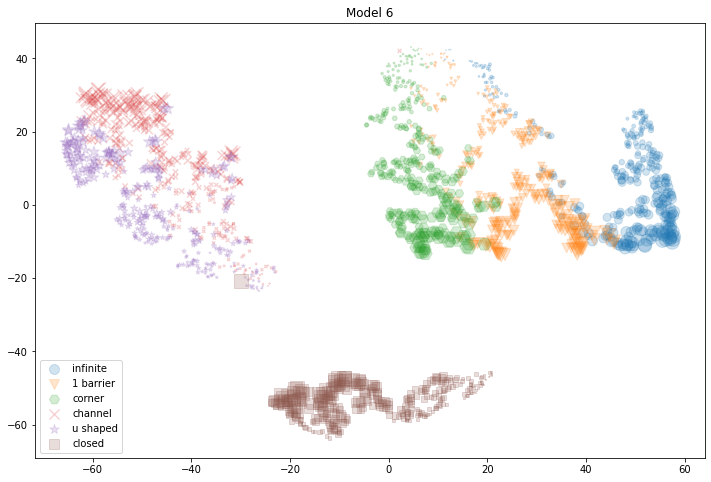

In [23]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
models = ["infinite", "1 barrier", "corner", "channel", "u shaped", "closed"]
markers = ["o", "v", "H", "x", "*", "s"]
for k,mdl in enumerate(models):
    ax.scatter(transformed_sets[5][np.where(labels == mdl), 0], 
               transformed_sets[5][np.where(labels == mdl), 1], 
               marker=markers[k], 
               alpha=0.2, 
               s=X_transmissibility[np.where(labels == mdl)],
               label=mdl)
    ax.set_title(f"Model {idx+1}")
    ax.legend()

**Usando o algoritmo UMAP**

A figura abaixo apresenta os resultados dos 6 modelos usando UMAP.

In [26]:
from umap import UMAP
labels = test_df[0].values
umap_sets = []
for i, dt in enumerate(data):
    umap_2d = UMAP(n_components=2, init='random', random_state=3)
    proj_2d = umap_2d.fit_transform(dt)
    umap_sets.append(proj_2d)
    print(f"UMAP {i+1} finished")

UMAP 1 finished
UMAP 2 finished
UMAP 3 finished
UMAP 4 finished
UMAP 5 finished
UMAP 6 finished


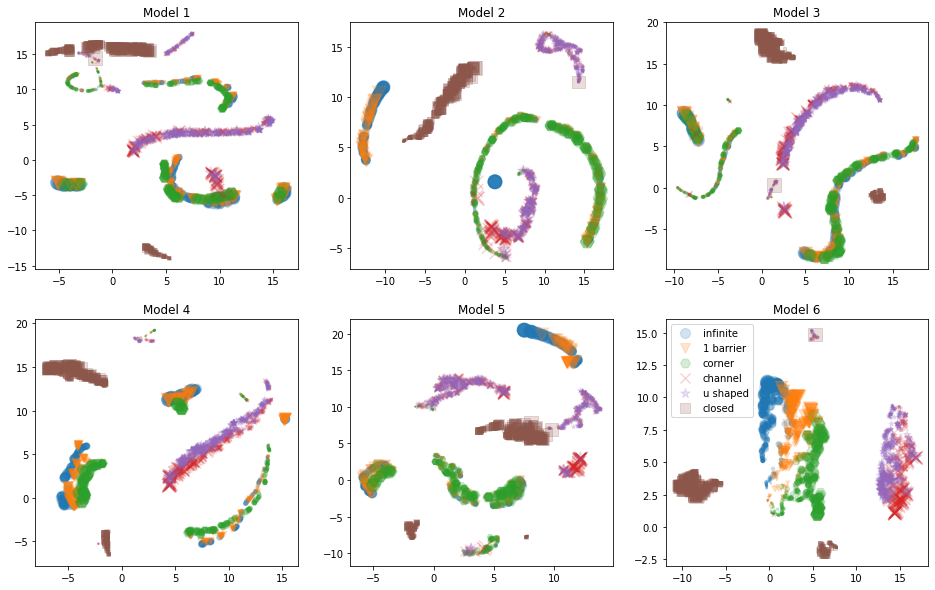

In [27]:
fig, ax = plt.subplots(2,3,figsize=(16,10))
model_names = ["infinite", "1 barrier", "corner", "channel", "u shaped", "closed"]
markers = ["o", "v", "H", "x", "*", "s"]
for i in range(2):
    for j in range(3):
        idx = 3*i + j
        for k,mdl in enumerate(model_names):
            ax[i,j].scatter(umap_sets[idx][np.where(labels == mdl), 0], 
                            umap_sets[idx][np.where(labels == mdl), 1], 
                            marker=markers[k], 
                            alpha=0.2, 
                            s=X_transmissibility[np.where(labels == mdl)],
                            label=mdl)
            ax[i,j].set_title(f"Model {idx+1}")
            if i == 1 and j == 2:
                ax[i,j].legend()

A figura abaixo apresenta os resultados do modelo 6 de forma ampliada usando UMAP.

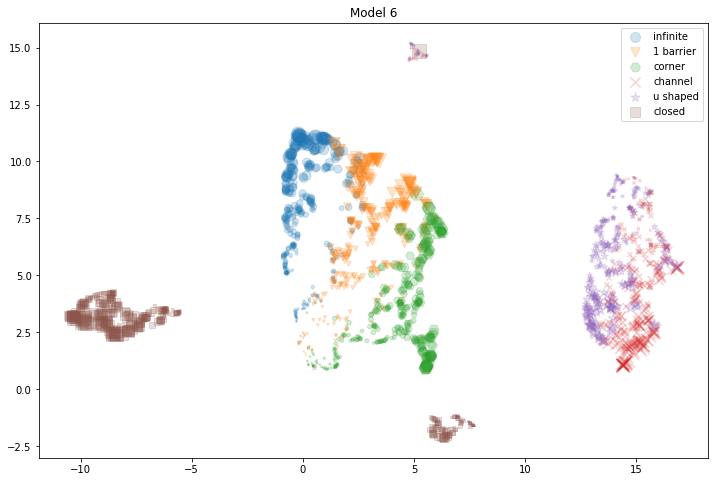

In [28]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
models = ["infinite", "1 barrier", "corner", "channel", "u shaped", "closed"]
markers = ["o", "v", "H", "x", "*", "s"]
for k,mdl in enumerate(models):
    ax.scatter(umap_sets[5][np.where(labels == mdl), 0], 
               umap_sets[5][np.where(labels == mdl), 1], 
               marker=markers[k], 
               alpha=0.2, 
               s=X_transmissibility[np.where(labels == mdl)],
               label=mdl)
    ax.set_title(f"Model {idx+1}")
    ax.legend()

## Conclusões

Apesar de nenhuma das redes ter atingido uma repetição perfeita dos valores de entrada, as camadas de codificação das redes autoencoders se mostraram capazes de segregar os diferentes modelos de barreiras no reservatório.

A análise de 6 diferentes conjuntos de entrada permitiu perceber a importância do uso de todos os dados disponíveis, e da sua inclusão do conhecimento físico, ao convertê-los em escala logarítimica.

Os únicos modelos que não apresentaram grande separação foram os reservatórios em formato de U e de canal. Esses casos são notadamente similares, e também geram dificuldades para os intérpretes humanos. Ainda assim, mesmo com os conjuntos próximos, há uma pequena separação entre os dois nas nuvens de pontos obtidas no T-SNE e no UMAP.

## Próximos passos

Esse estudo comprova a hipótese de que é possível chegar a uma representação mínima dos dados de teste de formação. Assim, os próximos passos consistem em avaliar a melhor forma de aplicar essa estratégia à conjuntos de dados reais.

Além disso, há espaço para a construção de features derivadas dos dados de entrada, como proposto por Tian, C. e Horne, R. N. (2015), em busca de uma segregação ainda melhor.